<a href="https://colab.research.google.com/github/Fhelyp/Case_PO_Prosper/blob/main/Case_Pr%C3%A1tico_PO_%7C_Lu%C3%A3_Fhelyp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração do ambiente

In [ ]:
# Bibliotecas e importações

!pip install pandas sqlalchemy matplotlib seaborn
import sqlite3
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt


# Criação e população do banco

In [ ]:
# Conectar banco
conn = sqlite3.connect('ecommerce_data.db')

# Criar tabelas
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Clientes (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        email TEXT,
        cidade TEXT
    );
''')
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Produtos (
        id INTEGER PRIMARY KEY,
        nome TEXT,
        preco REAL,
        categoria TEXT
    );
''')
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Vendas (
        id INTEGER PRIMARY KEY,
        cliente_id INTEGER,
        produto_id INTEGER,
        data_venda DATE,
        quantidade INTEGER,
        valor_total REAL,
        FOREIGN KEY (cliente_id) REFERENCES Clientes(id),
        FOREIGN KEY (produto_id) REFERENCES Produtos(id)
    );
''')
conn.commit()
conn.close()


In [ ]:
# Popular o banco com dados fictícios

# Dados teste
clientes_data = {
    'id': [1, 2, 3],
    'nome': ['Alice', 'Bob', 'Carol'],
    'email': ['alice@example.com', 'bob@example.com', 'carol@example.com'],
    'cidade': ['São Paulo', 'Rio de Janeiro', 'Belo Horizonte']
}
clientes_df = pd.DataFrame(clientes_data)

# Inserir dados no SQLite
conn = sqlite3.connect('ecommerce_data.db')
clientes_df.to_sql('Clientes', conn, if_exists='replace', index=False)
conn.close()


In [ ]:
# Conexão com o SQLAlchemy
engine = create_engine('sqlite:///ecommerce_data.db')

# Consulta
query = "SELECT * FROM Clientes"
clientes_df = pd.read_sql(query, engine)
clientes_df.head()


,id,nome,email,cidade
0,1,Alice,alice@example.com,São Paulo
1,2,Bob,bob@example.com,Rio de Janeiro
2,3,Carol,carol@example.com,Belo Horizonte


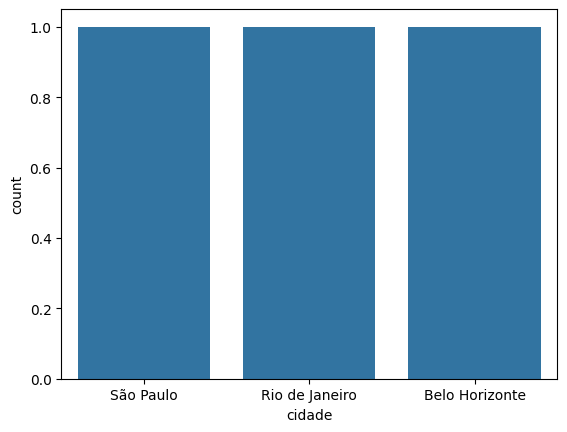

In [ ]:
# Visualização
sns.countplot(data=clientes_df, x='cidade')
plt.show()


 **📝 Nota**: Não encontrei um arquivo SQL para importar dados fictícios no banco, mas utilizei o Faker para gerar volumes de dados abaixo, e atender ao requisito do case:

> "milhares de registros"

In [ ]:
# Faker
!pip install faker

In [ ]:
from faker import Faker
import pandas as pd
import numpy as np
import sqlite3
import random
from datetime import datetime, timedelta

fake = Faker('pt_BR')
num_clientes = 1000
num_produtos = 500
num_vendas = 5000

# Gerar Clientes
clientes_data = {
    'id': range(1, num_clientes + 1),
    'nome': [fake.name() for _ in range(num_clientes)],
    'email': [fake.email() for _ in range(num_clientes)],
    'cidade': [fake.city() for _ in range(num_clientes)]
}
clientes_df = pd.DataFrame(clientes_data)

# Gerar Produtos
categorias = ['Eletrônicos', 'Roupas', 'Alimentos', 'Livros', 'Móveis']
produtos_data = {
    'id': range(1, num_produtos + 1),
    'nome': [fake.word().capitalize() for _ in range(num_produtos)],
    'preco': [round(fake.random_number(digits=3) + fake.random.random(), 2) for _ in range(num_produtos)],
    'categoria': [random.choice(categorias) for _ in range(num_produtos)]  # Usando random.choice para selecionar uma categoria aleatória
}
produtos_df = pd.DataFrame(produtos_data)

# Gerar Vendas
vendas_data = {
    'id': range(1, num_vendas + 1),
    'cliente_id': [fake.random_int(min=1, max=num_clientes) for _ in range(num_vendas)],
    'produto_id': [fake.random_int(min=1, max=num_produtos) for _ in range(num_vendas)],
    'data_venda': [fake.date_between(start_date='-1y', end_date='today') for _ in range(num_vendas)],
    'quantidade': [fake.random_int(min=1, max=5) for _ in range(num_vendas)],
    'valor_total': [round(fake.random_number(digits=3) + fake.random.random(), 2) * fake.random_int(min=1, max=5) for _ in range(num_vendas)]  # Corrigido para gerar o valor total da venda
}
vendas_df = pd.DataFrame(vendas_data)

# Popular tabelas
conn = sqlite3.connect('ecommerce_data.db')

clientes_df.to_sql('Clientes', conn, if_exists='replace', index=False)
produtos_df.to_sql('Produtos', conn, if_exists='replace', index=False)
vendas_df.to_sql('Vendas', conn, if_exists='replace', index=False)

conn.close()

print("Dados fictícios inseridos com sucesso!")

Dados fictícios inseridos com sucesso!


# Consultas básicas + extração (análise inicial)

In [ ]:
#  Produtos e preços
query_produtos = """
SELECT categoria,
       COUNT(*) as total_produtos,
       ROUND(AVG(preco), 2) as preco_medio,
       MIN(preco) as preco_minimo,
       MAX(preco) as preco_maximo
FROM Produtos
GROUP BY categoria
ORDER BY total_produtos DESC;
"""

# Vendas por período
query_vendas_periodo = """
SELECT
    strftime('%Y-%m', data_venda) as mes,
    COUNT(*) as total_vendas,
    ROUND(SUM(valor_total), 2) as valor_total_vendas,
    ROUND(AVG(valor_total), 2) as ticket_medio
FROM Vendas
GROUP BY mes
ORDER BY mes;
"""

# Clientes e volume de compras
query_top_clientes = """
WITH ClientesRanking AS (
    SELECT
        c.nome,
        c.cidade,
        COUNT(v.id) as total_compras,
        ROUND(SUM(v.valor_total), 2) as valor_total_gasto,
        ROUND(AVG(v.valor_total), 2) as ticket_medio,
        DENSE_RANK() OVER (ORDER BY SUM(v.valor_total) DESC) as ranking
    FROM Clientes c
    JOIN Vendas v ON c.id = v.cliente_id
    GROUP BY c.id, c.nome, c.cidade
)
SELECT *
FROM ClientesRanking
WHERE ranking <= 10;
"""

#  Sazonalidade
query_sazonalidade = """
SELECT
    strftime('%m', data_venda) as mes,
    p.categoria,
    COUNT(*) as total_vendas,
    ROUND(SUM(v.valor_total), 2) as valor_total,
    ROUND(AVG(v.valor_total), 2) as ticket_medio
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id
GROUP BY mes, p.categoria
ORDER BY mes, p.categoria;
"""

# Executar queries
def executar_analise(query, engine, titulo):
    # Executar query
    df = pd.read_sql(query, engine)
    print(f"\n=== {titulo} ===")
    print(df)
    return df

# Printar vizualizações
engine = create_engine('sqlite:///ecommerce_data.db')

df_produtos = executar_analise(query_produtos, engine, "Análise de Produtos por Categoria")
df_vendas = executar_analise(query_vendas_periodo, engine, "Análise de Vendas por Período")
df_clientes = executar_analise(query_top_clientes, engine, "Top 10 Clientes")
df_sazonalidade = executar_analise(query_sazonalidade, engine, "Análise de Sazonalidade")


=== Análise de Produtos por Categoria ===
     categoria  total_produtos  preco_medio  preco_minimo  preco_maximo
0       Livros             109       501.38          3.63        996.77
1  Eletrônicos             107       453.65          5.29        998.45
2       Roupas             102       528.45          0.88        992.40
3       Móveis              98       501.10          0.18        996.30
4    Alimentos              84       515.39         21.38        990.47

=== Análise de Vendas por Período ===
        mes  total_vendas  valor_total_vendas  ticket_medio
0   2023-11           250           376478.20       1505.91
1   2023-12           445           658207.81       1479.12
2   2024-01           461           689416.16       1495.48
3   2024-02           416           620985.01       1492.75
4   2024-03           437           610455.12       1396.92
5   2024-04           418           598703.91       1432.31
6   2024-05           426           583128.21       1368.85
7   20

In [ ]:
# Análise de produtos
query_produtos_populares = """
WITH ProdutosVendidos AS (
    SELECT
        p.categoria,
        p.nome as produto,
        COUNT(v.id) as total_vendas,
        SUM(v.quantidade) as quantidade_total,
        ROUND(SUM(v.valor_total), 2) as receita_total,
        RANK() OVER (
            PARTITION BY p.categoria
            ORDER BY COUNT(v.id) DESC
        ) as posicao_categoria
    FROM Produtos p
    JOIN Vendas v ON p.id = v.produto_id
    GROUP BY p.categoria, p.nome
)
SELECT
    categoria,
    produto,
    total_vendas,
    quantidade_total,
    receita_total,
    'Top ' || posicao_categoria as ranking
FROM ProdutosVendidos
WHERE posicao_categoria <= 3  -- Mostra apenas os 3 mais vendidos de cada categoria
ORDER BY categoria, posicao_categoria;
"""

# Executar a query
engine = create_engine('sqlite:///ecommerce_data.db')
df_produtos_populares = pd.read_sql(query_produtos_populares, engine)

# Mostrar resultados de forma mais organizada
print("\nProdutos mais vendidos por categoria:")
for categoria in df_produtos_populares['categoria'].unique():
    print(f"\n=== {categoria} ===")
    produtos_categoria = df_produtos_populares[df_produtos_populares['categoria'] == categoria]
    print(produtos_categoria[['produto', 'total_vendas', 'quantidade_total', 'receita_total', 'ranking']].to_string(index=False))


Produtos mais vendidos por categoria:

=== Alimentos ===
produto  total_vendas  quantidade_total  receita_total ranking
   Fuga            33               102       51279.73   Top 1
  Sequi            32                87       52223.69   Top 2
Tempore            27                77       46340.81   Top 3

=== Eletrônicos ===
produto  total_vendas  quantidade_total  receita_total ranking
   Quod            30               100       50504.04   Top 1
    Sit            29                88       42358.68   Top 2
Ratione            28                79       42597.58   Top 3

=== Livros ===
produto  total_vendas  quantidade_total  receita_total ranking
  Nulla            34               106       44122.05   Top 1
   Sint            32                95       35573.09   Top 2
  Culpa            30               101       44906.38   Top 3

=== Móveis ===
     produto  total_vendas  quantidade_total  receita_total ranking
    Deserunt            31                87       44287.55   Top

# Consultas avançadas e visualização de dados

In [ ]:
# Importação

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np

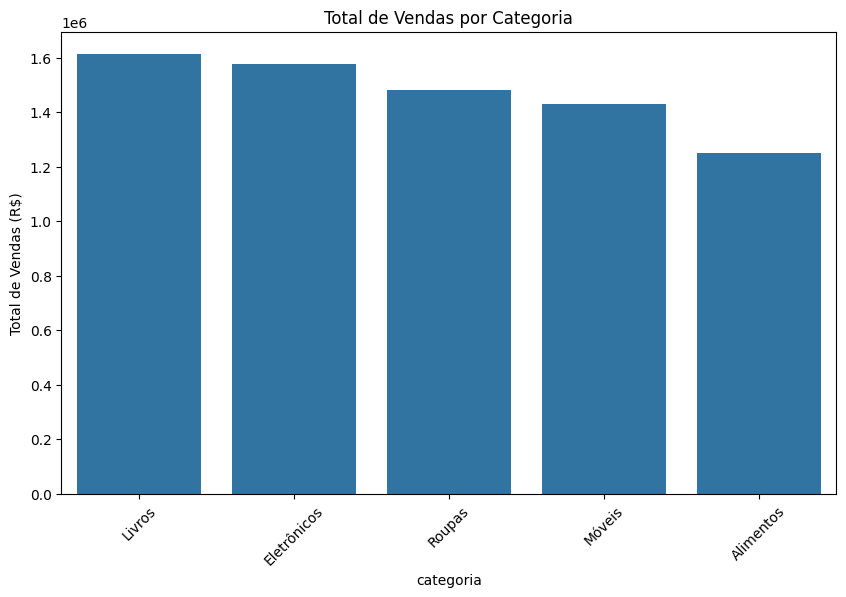

In [ ]:
# Análise 1: vendas/categoria
query_vendas_categoria = """
SELECT
    p.categoria,
    COUNT(*) as num_vendas,
    ROUND(SUM(v.valor_total), 2) as total_vendas
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id
GROUP BY p.categoria
ORDER BY total_vendas DESC;
"""

df_vendas_cat = pd.read_sql(query_vendas_categoria, engine)

# Gráfico de vendas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_vendas_cat, x='categoria', y='total_vendas')
plt.title('Total de Vendas por Categoria')
plt.xticks(rotation=45)
plt.ylabel('Total de Vendas (R$)')
plt.show()

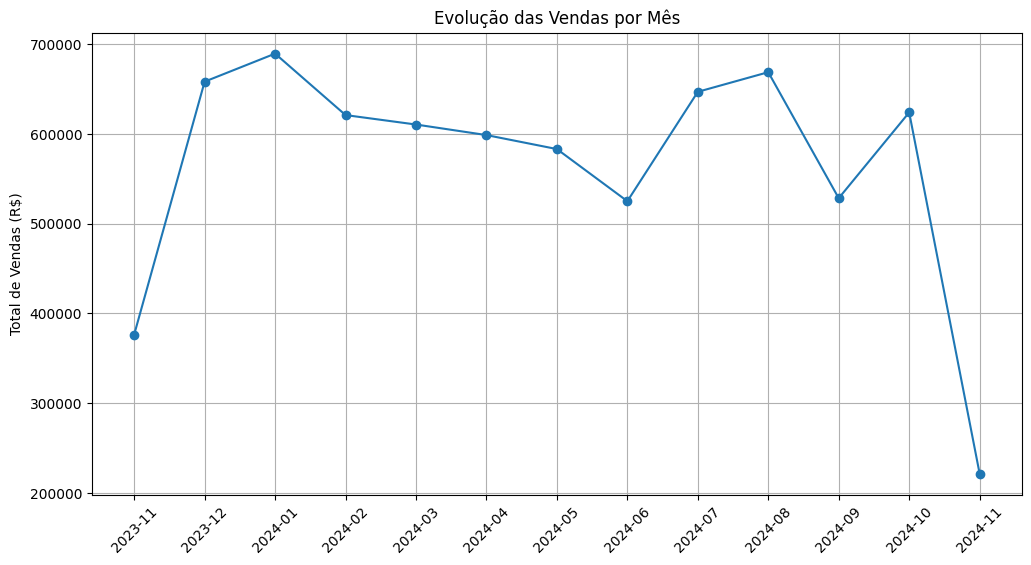

In [ ]:
# Análise 2: Vendas ao longo do tempo
query_vendas_tempo = """
SELECT
    strftime('%Y-%m', data_venda) as mes,
    COUNT(*) as num_vendas,
    ROUND(SUM(valor_total), 2) as total_vendas
FROM Vendas
GROUP BY mes
ORDER BY mes;
"""

df_vendas_tempo = pd.read_sql(query_vendas_tempo, engine)

# Gráfico de linha --- vendas por mês
plt.figure(figsize=(12, 6))
plt.plot(df_vendas_tempo['mes'], df_vendas_tempo['total_vendas'], marker='o')
plt.title('Evolução das Vendas por Mês')
plt.xticks(rotation=45)
plt.ylabel('Total de Vendas (R$)')
plt.grid(True)
plt.show()

<ipython-input-92-a0eb369a7195>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cidades, x='cidade', y='total_vendas', palette='viridis')


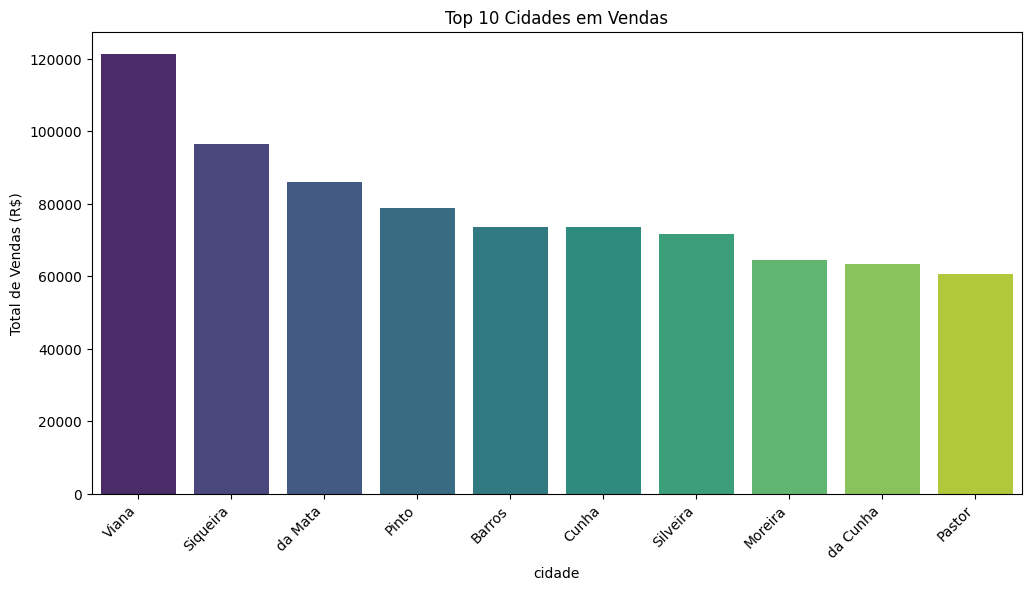

In [ ]:
# Análise 3: Cidades que mais compram
query_cidades = """
SELECT
    c.cidade,
    COUNT(*) as num_vendas,
    ROUND(SUM(v.valor_total), 2) as total_vendas
FROM Vendas v
JOIN Clientes c ON v.cliente_id = c.id
GROUP BY c.cidade
ORDER BY total_vendas DESC
LIMIT 10;
"""

df_cidades = pd.read_sql(query_cidades, engine)

# Gráfico das cidades
plt.figure(figsize=(12, 6))
sns.barplot(data=df_cidades, x='cidade', y='total_vendas', palette='viridis')
plt.title('Top 10 Cidades em Vendas')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total de Vendas (R$)')
plt.show()

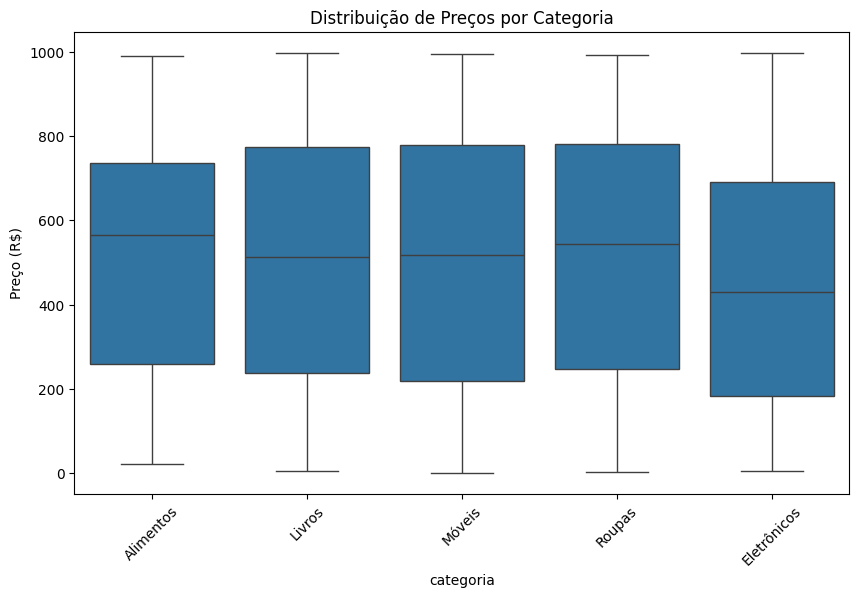

In [ ]:
# Análise 4: Distribuição de preços/categoria
query_precos = """
SELECT categoria, preco
FROM Produtos;
"""

df_precos = pd.read_sql(query_precos, engine)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_precos, x='categoria', y='preco')
plt.title('Distribuição de Preços por Categoria')
plt.xticks(rotation=45)
plt.ylabel('Preço (R$)')
plt.show()

<ipython-input-94-c38820b4c853>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dia_semana, x='dia_semana', y='num_vendas', palette='Set3')


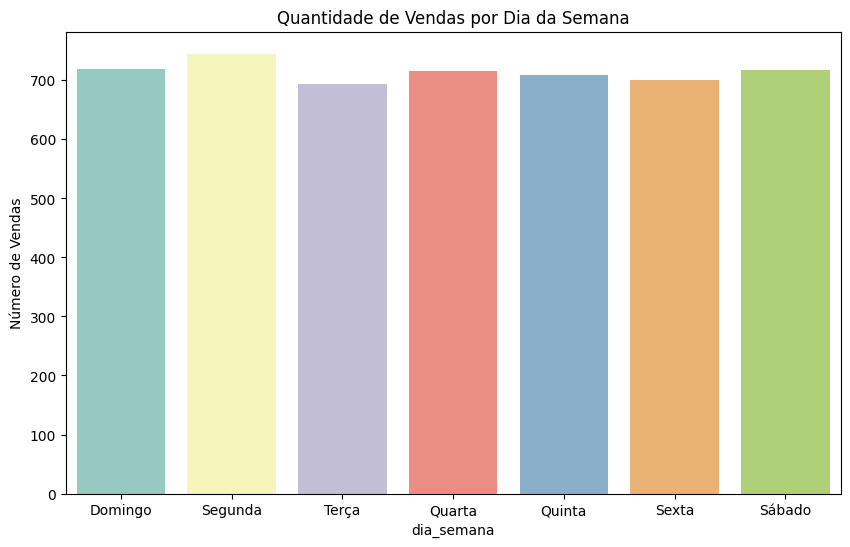

In [ ]:
# Análise 5: Quantidade de vendas/dia da semana
query_dia_semana = """
SELECT
    CASE cast(strftime('%w', data_venda) as integer)
        WHEN 0 THEN 'Domingo'
        WHEN 1 THEN 'Segunda'
        WHEN 2 THEN 'Terça'
        WHEN 3 THEN 'Quarta'
        WHEN 4 THEN 'Quinta'
        WHEN 5 THEN 'Sexta'
        WHEN 6 THEN 'Sábado'
    END as dia_semana,
    COUNT(*) as num_vendas
FROM Vendas
GROUP BY dia_semana
ORDER BY cast(strftime('%w', data_venda) as integer);
"""

df_dia_semana = pd.read_sql(query_dia_semana, engine)

# Gráfico de vendas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dia_semana, x='dia_semana', y='num_vendas', palette='Set3')
plt.title('Quantidade de Vendas por Dia da Semana')
plt.ylabel('Número de Vendas')
plt.show()

In [ ]:
# Insights
total_vendas = df_vendas_cat['total_vendas'].sum()
categoria_mais_vendida = df_vendas_cat.iloc[0]['categoria']
cidade_mais_compra = df_cidades.iloc[0]['cidade']

print("👉 Insights:\n")
print(f"Total de vendas: R$ {total_vendas:,.2f}")
print(f"Categoria que mais vendeu: {categoria_mais_vendida}")
print(f"Cidade que mais compra: {cidade_mais_compra}")

👉 Insights:

Total de vendas: R$ 7,352,052.17
Categoria que mais vendeu: Livros
Cidade que mais compra: Viana


<ipython-input-96-68414b232c82>:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = pd.pivot_table(


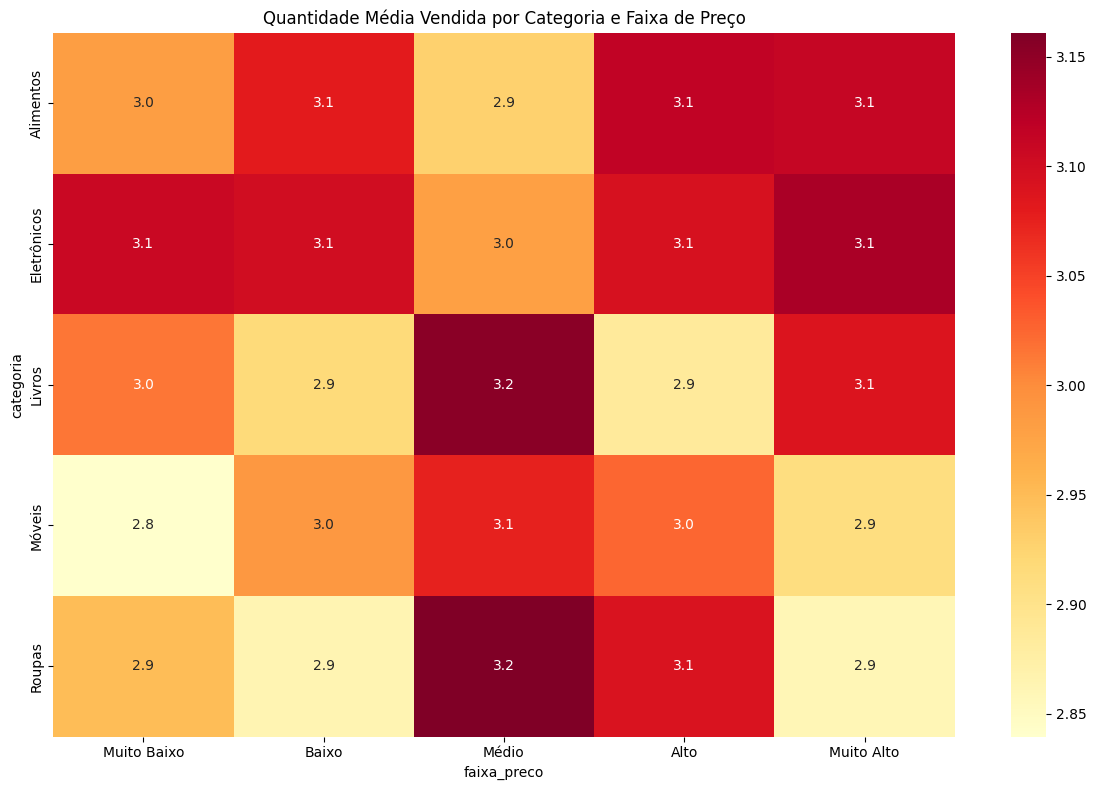

In [ ]:
# Correlação entre preço e quantidade vendida
query_preco_qtd = """
SELECT
    p.preco,
    v.quantidade,
    p.categoria
FROM Vendas v
JOIN Produtos p ON v.produto_id = p.id;
"""
df_preco_qtd = pd.read_sql(query_preco_qtd, engine)

# Cria faixas de preço para visualização
df_preco_qtd['faixa_preco'] = pd.qcut(df_preco_qtd['preco'], q=5, labels=['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto'])

# Heatmap
plt.figure(figsize=(12, 8))
heatmap_data = pd.pivot_table(
    df_preco_qtd,
    values='quantidade',
    index='categoria',
    columns='faixa_preco',
    aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Quantidade Média Vendida por Categoria e Faixa de Preço')
plt.tight_layout()
plt.show()

In [ ]:
# Consolidados
print("Descobertas: \n")
print(f"1. Horário com mais vendas: {df_hora.loc[df_hora['num_vendas'].idxmax(), 'hora']}h")
print(f"2. Horário com maior ticket médio: {df_hora.loc[df_hora['ticket_medio'].idxmax(), 'hora']}h")

# Maior e menor crescimento
df_periodos['crescimento_mes_anterior'] = df_periodos['crescimento_mes_anterior'].fillna(0)
melhor_mes = df_periodos.loc[df_periodos['crescimento_mes_anterior'].idxmax(), 'mes']
pior_mes = df_periodos.loc[df_periodos['crescimento_mes_anterior'].idxmin(), 'mes']

print(f"3. Mês com maior crescimento: {melhor_mes}")
print(f"4. Mês com menor crescimento: {pior_mes}")

# Categorias com maior e menor variação de preço
cv_precos = df_stats.groupby('categoria')['preco'].agg(lambda x: x.std()/x.mean()).sort_values(ascending=False)
print(f"5. Categoria com maior variação de preço: {cv_precos.index[0]}")
print(f"6. Categoria com menor variação de preço: {cv_precos.index[-1]}")

Descobertas: 

1. Horário com mais vendas: 0h
2. Horário com maior ticket médio: 0h
3. Mês com maior crescimento: 2023-12
4. Mês com menor crescimento: 2024-11
5. Categoria com maior variação de preço: Livros
6. Categoria com menor variação de preço: Móveis


# Transformação e limpeza de dados

**7. Transformação e Limpeza de Dados:**

- Realize transformações nos dados extraídos diretamente no Jupyter Notebook, aplicando técnicas de data wrangling com pandas.
- Limpe os dados, tratando valores nulos, inconsistências e duplicatas.
- Crie novas colunas derivadas de informações existentes, como:Tempo médio de compra de clientes.Margem de lucro dos produtos vendidos.
- Utilize funções SQL ou pandas para gerar novas métricas e insights.

**8. Análise de Performance SQL e Otimização:**

- Avalie o desempenho das consultas SQL, utilizando ferramentas como EXPLAIN para analisar o plano de execução.
- Otimize consultas SQL ajustando índices no banco de dados e utilizando técnicas como particionamento de tabelas para melhorar a eficiência de grandes extrações de dados.
- Ajuste as consultas para reduzir o tempo de execução, especialmente para grandes volumes de dados.

**9. Relatório Final no Jupyter Notebook:**

- Compile os resultados da análise e visualize os insights principais em um relatório interativo no Jupyter Notebook.
- Combine as consultas SQL com os gráficos e análises geradas no notebook, estruturando uma narrativa clara que explique os principais resultados.
- Use markdown no Jupyter para documentar o processo, detalhando cada análise e justificando as escolhas feitas.

**10. Exportação de Resultados:**

- Exporte as tabelas e visualizações geradas em arquivos CSV ou Excel, permitindo que os resultados sejam compartilhados ou usados em outras ferramentas.
- Integre o Jupyter Notebook com Dashboards (como Tableau, Power BI ou Plotly Dash) para criar relatórios interativos e acessíveis para outras partes interessadas.

**Observações**

- **Consultas SQL Eficientes:** Escreva consultas SQL que sejam claras e eficientes, evitando redundâncias e garantindo que as extrações de dados sejam otimizadas.
- **Transformação e Limpeza de Dados:** Utilize o Jupyter Notebook para realizar transformações e análises avançadas nos dados extraídos, garantindo que os insights obtidos sejam precisos e úteis.
- **Integração SQL com Jupyter:** Certifique-se de que o pipeline de extração de dados do banco de dados para o Jupyter Notebook esteja bem definido, garantindo a consistência entre as análises.
- **Análises Avançadas e Visualizações:** Aplique técnicas de visualização de dados e análise estatística para revelar padrões, tendências e insights escondidos nos dados.